# Mandelbrot Set GPU version

Daniel Köhn

Kiel, 22.10.2020

GPU code by Mark Harris:

[Numba Examples](https://github.com/harrism/numba_examples)

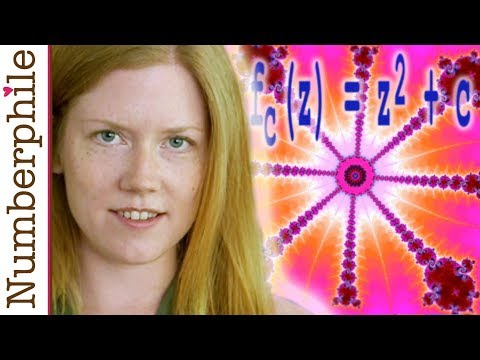

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('NGMRB4O922I')    

In [1]:
# import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import autojit

## Compute and visualize the Mandelbrot set 

In [2]:
@autojit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

In [3]:
# Import CUDA 
from numba import cuda
from numba import *

mandel_gpu = cuda.jit(device=True)(mandel)

In [4]:
# Create Mandelbrot set
@cuda.jit
def mandel_kernel(width, height, Re_min, Re_max, Im_min, Im_max, image, maxit):

  # define pixel size
  pixel_size_x = (Re_max - Re_min) / width
  pixel_size_y = (Im_max - Im_min) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for i in range(startX, width, gridX):
    real = Re_min + i * pixel_size_x
    for j in range(startY, height, gridY):
      imag = Im_min + j * pixel_size_y 
      image[j, i] = mandel_gpu(real, imag, maxit)

dshrink =  1.0392156081608734


<IPython.core.display.Javascript object>


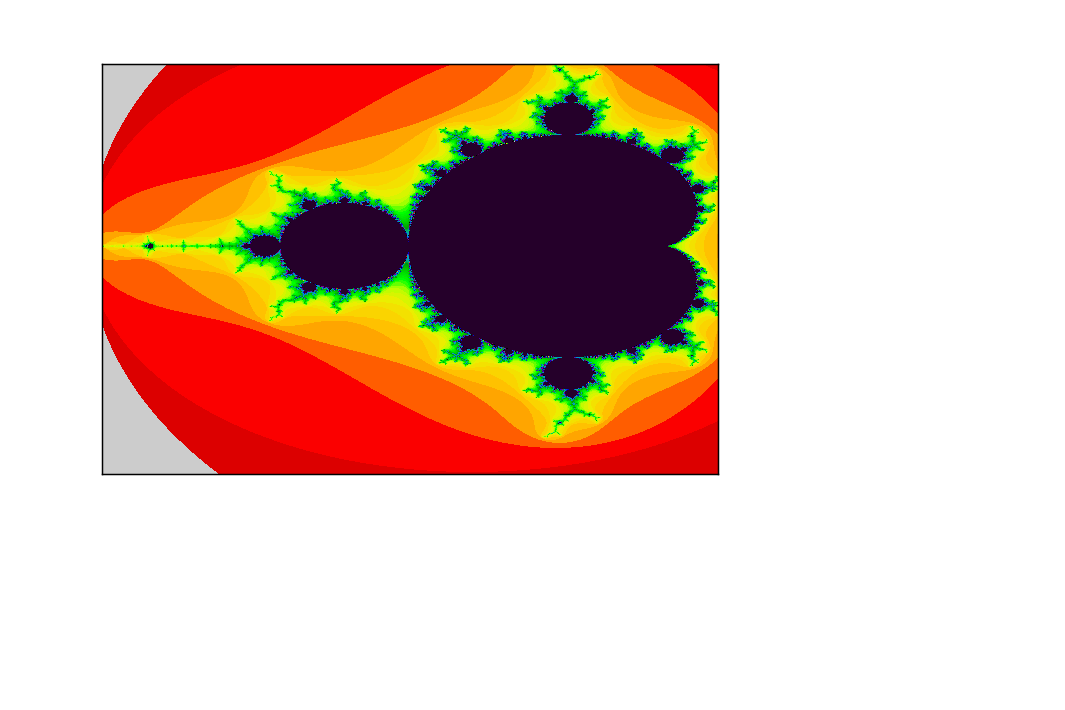

Wall time: 35min 46s


In [5]:
%%time
%matplotlib notebook
# Compute Mandelbrot set

# define image size
width = 1536 * 4
height = 1024 * 4

# define maximum number of iterations
maxit = 3000

gimage = np.zeros((height, width), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

# define center of frame
Re_c = -0.743643887037158704752191506114774 
Im_c = 0.131825904205311970493132056385139

# define rate at which the frame shrinks
#shrink = 0.000001
shrink_start = 2.5
shrink_end = 0.0000005
nshrink = 401

dshrink = np.exp(np.log(shrink_start / shrink_end) / nshrink)

print('dshrink = ', dshrink)

shrink = shrink_end

# Visualize Mandelbrot Set
fig = plt.figure(figsize=(6,4))  # define figure size
x = gimage
image1 = plt.imshow(x,cmap='nipy_spectral_r',vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])

plt.ion()    
plt.show(block=False)

for k in range(nshrink):    
    
    # define boundaries of complex plane
    Re_half = 0.5 * shrink
    Im_half = 0.5 * shrink

    Re_min = Re_c - Re_half
    Re_max = Re_c + Re_half

    Im_min = Im_c - Im_half
    Im_max = Im_c + Im_half

    # Create Mandelbrot set on GPU
    d_image = cuda.to_device(gimage)
    mandel_kernel[griddim, blockdim](width, height, Re_min, Re_max, Im_min, Im_max, d_image, maxit)
    d_image.to_host()

    # Postprocess Mandelbrot Set
    x = (gimage - np.min(gimage)) / (np.max(gimage) - np.min(gimage))
    x = x**(1/3.5)
    x = (np.sin(x * np.pi - np.pi / 2) + 1) / 2
    
    # Update Mandelbrot snapshot 
    image1.set_data(x)
    fig.canvas.draw()
    
    if (k<999):
        filename = 'pics/mandelbrot_0' + str(k+1) + '.jpg'
    
    if (k<99):
        filename = 'pics/mandelbrot_00' + str(k+1) + '.jpg'
    
    if (k<9):
        filename = 'pics/mandelbrot_000' + str(k+1) + '.jpg'
    
    plt.savefig(filename, format='jpeg', bbox_inches='tight',dpi=1000)
    
    shrink *= dshrink 

#### Final Mandelbrot zoom video

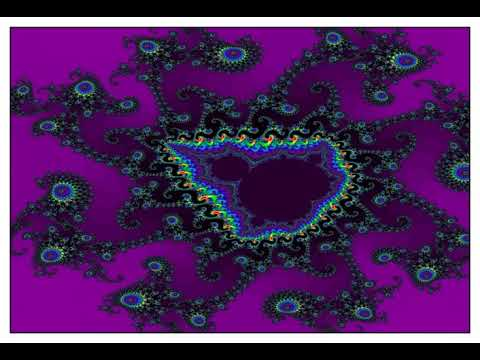

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('bVOPhQIQzlk')

In [ ]:
# Visualize Mandelbrot set
plt.figure(dpi=700)
#plt.imshow(mandel.T, cmap='gist_ncar_r', extent = [Re_min,Re_max,Im_min,Im_max])
#plt.imshow(mandel.T, cmap='twilight_r')
plt.imshow(mandel.T, cmap='flag',)
#plt.imshow(mandel.T, cmap='prism')
#plt.imshow(mandel.T, cmap='nipy_spectral_r')
#plt.xlabel('Re')
#plt.ylabel('Im')
plt.xticks([])
plt.yticks([])
plt.savefig('mandelbrot.pdf', format='pdf', bbox_inches='tight')
plt.show()